# **Excercise 2: Deformation of an undamped SDOF under forcing using  Physics-informed Neural Networks (PINNs)**

In [ ]:
!pip install sciann
import sciann as sn 
import numpy as np 
import matplotlib.pyplot as plt 

**Define the vibration problem of the undampened SDOF under force action**

Find a figure of the problem here: 

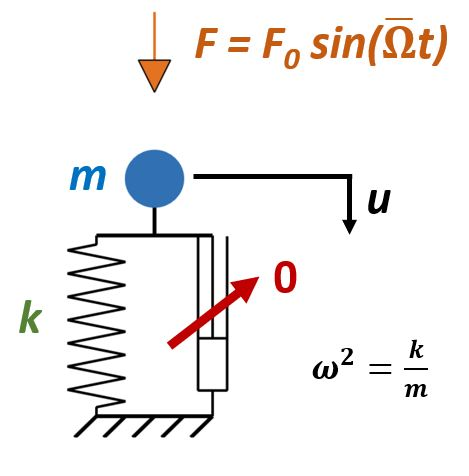

Text(0.5, 1.0, 'Analytical reference solution of the deflection [m]')

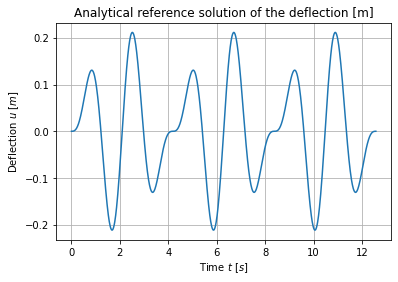

In [ ]:
Omega = 3                                 # Eigen circular frequency of the mass-stiffness-system [rad/s]
OmegaBar = Omega*1.5                      # Eigen circular frequency of the forcing action [rad/s]
F0 = 1                                    # Amplitude of the forcing action [MN]
A0 = F0/(Omega**2 - OmegaBar**2)          # Amplitude of the deflection (analytical reference solution) [m]
Beta = OmegaBar/Omega                     # Frequency ratio of forcing action and Eigen circular frequency

_response = lambda t: A0*(np.sin(OmegaBar*t) - Beta*np.sin(Omega*t))    # Analytical reference solution of the deflection [m]

t_data = np.concatenate([np.linspace(0, 0., 1000), np.linspace(0, 4*np.pi, 1000)])
u_data = _response(t_data)

plt.plot(t_data, u_data)
plt.ylabel('Deflection $u~[m]$')
plt.xlabel('Time $t~[s]$')
plt.grid('on')
plt.title('Analytical reference solution of the deflection [m]')

# **Definition of the Physics-Informed Neural Network for Deformation of an undamped SDOF under forcing**

In [ ]:
# sn.clear_session()
t = sn.Variable('t')                                                          # Define input variables (Features)
u = sn.Functional('u', t, 4*[20], 'sin')                                      # Define Neurale Network
L1 = sn.diff(u, t, order=2) + Omega**2*u - F0*sn.sin(OmegaBar*t)              # Define Differential Equation / Physics
L2 = (1 - sn.sign(t)) * u                                                     # Define Boundary Conditions u(t = 0) = 0
L3 = (1 - sn.sign(t)) * sn.diff(u, t)                                         # Define Initial Conditions u'(t = 0) = 0

In [ ]:
# Option 1: ADAM Optimiser 
model = sn.SciModel([t], [sn.PDE(L1),L2,L3], optimizer='adam')

# Option 2: BFGS Optimiser 
# model = sn.SciModel([t], [sn.PDE(L1),L2,L3], optimizer='scipy-l-bfgs-b')  

# **Training of the Physics-Informed Neural Network for Deformation of an undamped SDOF under forcing**

In [ ]:
h = model.train(
    t_data, 
    ['zeros', 'zeros', 'zeros'], 
    epochs=1000, 
    reduce_lr_after=100,    # only relevant for Option 1
    adaptive_weights=100,   
    batch_size=100,
    verbose=1
)


Total samples: 2000 
Batch size: 100 
Total batches: 20 


+ NTK evaluation time [s]: 0.6467981338500977 

+ adaptive_weights at epoch 1: [0.10549306655448003, 2.667916246846793, 0.2265906865987265]
Epoch 1/1000
20/20 [==============================] - 3s 11ms/step - batch: 9.5000 - size: 100.0000 - loss: 0.4018 - sub_loss: 3.6662 - mul_4_loss: 0.0018 - mul_5_loss: 0.0450 - lr: 0.0010 - time: 4.1799 - loss_weight_0: 0.1055 - loss_weight_1: 2.6679 - loss_weight_2: 0.2266 - loss_gradient_0: 20243.9942 - loss_gradient_1: 50.3145 - loss_gradient_2: 1020.6397
Epoch 2/1000
20/20 [==============================] - 0s 3ms/step - batch: 9.5000 - size: 100.0000 - loss: 0.0515 - sub_loss: 0.4620 - mul_4_loss: 5.9165e-04 - mul_5_loss: 0.0053 - lr: 0.0010 - time: 0.1031 - loss_weight_0: 0.1055 - loss_weight_1: 2.6679 - loss_weight_2: 0.2266 - loss_gradient_0: 20243.9942 - loss_gradient_1: 50.3145 - loss_gradient_2: 1020.6397
Epoch 3/1000
20/20 [==============================] - 0s 4ms/step - batch

# **Evaluation of the Physics-Informed Neural Network for Deformation of an undamped SDOF under forcing**

**1. Convergence Plot of the PINN**

Text(0.5, 1.0, 'Convergence of the PINN')

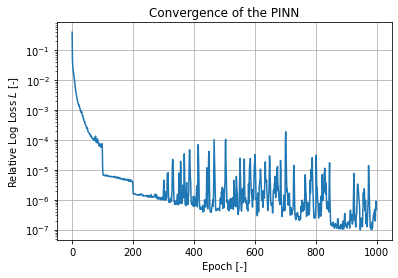

In [ ]:
plt.semilogy(h.history['loss'])
plt.ylabel('Relative Log Loss $L$ [-]')
plt.xlabel('Epoch [-]')
plt.grid('on')
#plt.ylim(10**-9,10**-6)
plt.title('Convergence of the PINN')

**2. Graphical comparison of the system responses of the PINN and the analytical reference solution**

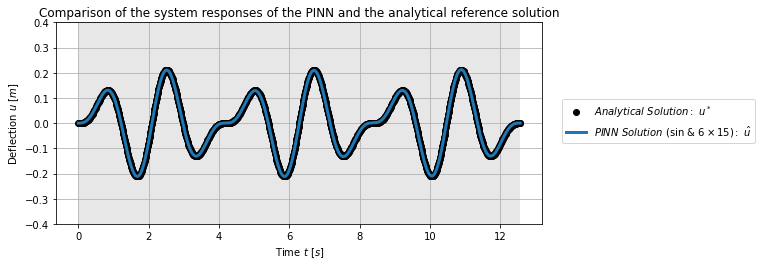

In [ ]:
t_test = np.linspace(0, 4*np.pi, 1000)

fig, ax = plt.subplots(1,1,figsize=(9,4))
ax.axvspan(0, 4*np.pi, facecolor='0.1', alpha=0.1)
ax.plot(t_test, _response(t_test), 'ok', lw=6, label='$Analytical~Solution:~u^*$') 
ax.plot(t_test, u.eval(t_test), lw=3, label='$PINN~Solution~(\\mathrm{sin}~&~6 \\times 15):~\hat{u}$') 
ax.set_title('Comparison of the system responses of the PINN and the analytical reference solution')
plt.grid('on')

ax.set_xlabel('Time $t~[s]$')
ax.set_ylabel('Deflection $u~[m]$')
ax.set_ylim(-.4,.4)
ax.legend(loc=(1.04,0.4))
plt.subplots_adjust(0.1, 0.15, 0.85, 0.85, 0.3, 0.3)        # the gray highlighted are indicates the training interval
#plt.savefig('Forced-Vibration.pdf', pdi=300)